# Mullti-task Learning on Cifar10 Dataset: A CNN Approach
- Name: Minh T. Nguyen, Peter Chen
- ECE 6524 - Final Project
- Date: 4/14/2023
- **Objective**: Build a MTL model for image classification.
    - Task 1: Multi-class classification (airplane, automobile, bird, cat, deer, dog, frog, horse ship, truck).
    - Task 2: Super-class binary classification (animal, vehicle)
    
- **To Do**:
    - Experience with Different Model Configuration: 
        - Optimizers
        - Regularization: Dropout

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import np_utils, plot_model
from keras.layers import Input, Dropout, Flatten, Dense
from keras.applications.resnet import ResNet152, preprocess_input
from keras import Model

In [2]:
tf.version.VERSION

'2.11.0'

# 1. Data Visualization & Preprocessing

# 1.1 Data Visualization

In [3]:
# download data from Keras API
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


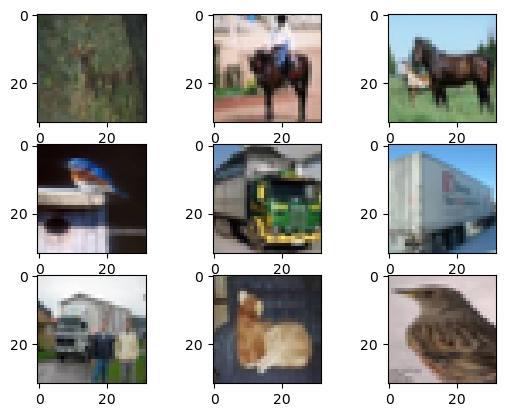

In [5]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Creating Superclasses
The super-classes are divided into animals and vehicles:
- **Animals**: Bird, Cat, Deer, Dog, Frog, Horse. (5000x6 training images, 1000x6 testing images).
- **Vehicles**: Airplane, Automotive, Ship, Truck. (5000x4 training images, 1000x4 testing images).

From [Cifar 10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html), we know that the labels have the corresponding label number:
- Airplane: 0.
- Automobile: 1.
- Bird: 2.
- Cat: 3.
- Deer: 4.
- Dog: 5.
- Frog: 6.
- Horse: 7.
- Ship: 8.
- Truck 9.

In [6]:
# define superclasses (0 = animal, 1 = vehicle)
animal_classes = [2, 3, 4, 5, 6, 7]
y_train_super = [0 if y in animal_classes else 1 for y in y_train ] 
y_test_super = [0 if y in animal_classes else 1 for y in y_test]

print(len(y_train_super))
print(len(y_test_super))

50000
10000


In [7]:
# check labels for accuracy (referencing image plotted above)
print(y_train_super[10:19])

[0, 0, 0, 0, 1, 1, 1, 0, 0]


## 1.3. Data Processing

In [8]:
# normalize input data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# convert class into one hot encoder
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('\ny_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

# convert class into one hot encoder
y_train_super = np_utils.to_categorical(y_train_super)
y_test_super = np_utils.to_categorical(y_test_super)

print('\ny_train_super shape: ', y_train_super.shape)
print('y_test_super shape: ', y_test_super.shape)

X_train shape:  (50000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)

y_train shape:  (50000, 10)
y_test shape:  (10000, 10)

y_train_super shape:  (50000, 2)
y_test_super shape:  (10000, 2)


# 2. Modeling

In [9]:
# Define ResNet152 CNN model
def create_model(dropout):
    input_shape = (32, 32, 3)
    
    resnet152_base = ResNet152(weights=None, include_top=False, input_shape=input_shape)
    
    
    # shared back-bone: convolution - feature extractor
    inputs = Input(shape=input_shape, name='input')
    shared_branch = resnet152_base(inputs)
    shared_branch = Flatten()(shared_branch)
    shared_branch = Dense(2048, activation='relu')(shared_branch)
    
    # task 1 branch - fully connected for 10-class classification
    task_1_branch = Dense(1024, activation='relu')(shared_branch)
    task_1_branch = Dropout(dropout)(task_1_branch) 
    task_1_branch = Dense(512, activation="relu")(task_1_branch)
    task_1_branch = Dense(256, activation="relu")(task_1_branch)
    task_1_branch = Dense(128, activation="relu")(task_1_branch)
    task_1_branch = Dense(10, activation="softmax", name="task_1_output")(task_1_branch)
    
    # task 1 branch - fully connected for binary superclass classification
    task_2_branch = Dense(512, activation='relu')(shared_branch)
    task_2_branch = Dropout(dropout)(task_2_branch)
    task_2_branch = Dense(256, activation="relu")(task_2_branch)
    task_2_branch = Dense(128, activation="relu")(task_2_branch)
    task_2_branch = Dense(2, activation="softmax", name="task_2_output")(task_2_branch)
    
    # modeling
    model = Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resnet152 (Functional)         (None, 1, 1, 2048)   58370944    ['input[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['resnet152[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 2048)         4196352     ['flatten[0][0]']                
                                                                                              

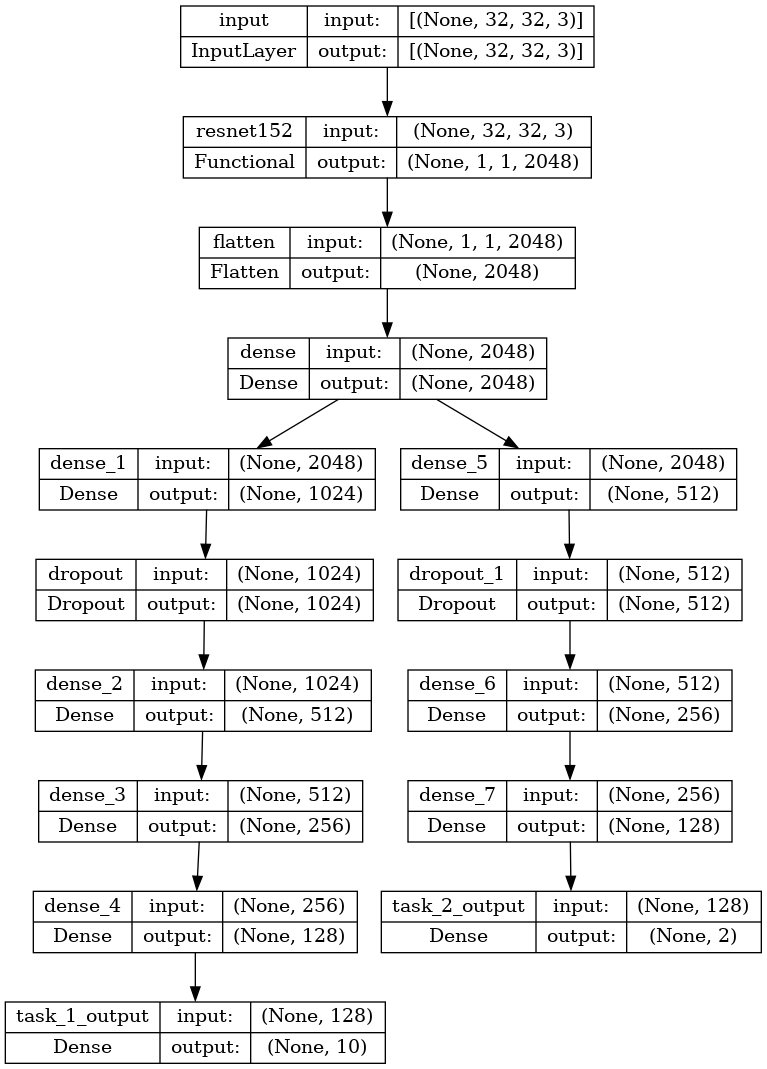

In [10]:
# display and plot model
model = create_model(0)
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# define number of epochs and batch size
epochs = 20
batch_size = 256

## 2.1. Case 1: Gamma = 0.5 - The model will receive the loss evenly in both tasks
##      (Dropout = 0, Optimizer = Adam)

In [12]:
# define parameters and generate model
gamma=0.5
dropout = 0
optimizer = 'Adam'
model_1 = create_model(dropout)

In [13]:
# compile model
model_1.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [14]:
# train model
history_1 = model_1.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 145s 215ms/step - loss: 1.2546 - task_1_output_loss: 2.0700 - task_2_output_loss: 0.4391 - task_1_output_accuracy: 0.1808 - task_2_output_accuracy: 0.8014 - val_loss: 1.5152 - val_task_1_output_loss: 2.2989 - val_task_2_output_loss: 0.7314 - val_task_1_output_accuracy: 0.1100 - val_task_2_output_accuracy: 0.6155
Epoch 2/20
167/167 [==============================] - 31s 188ms/step - loss: 1.0819 - task_1_output_loss: 1.8791 - task_2_output_loss: 0.2847 - task_1_output_accuracy: 0.2279 - task_2_output_accuracy: 0.8849 - val_loss: 1.1550 - val_task_1_output_loss: 1.9693 - val_task_2_output_loss: 0.3407 - val_task_1_output_accuracy: 0.2411 - val_task_2_output_accuracy: 0.8869
Epoch 3/20
167/167 [==============================] - 32s 194ms/step - loss: 1.1717 - task_1_output_loss: 1.9809 - task_2_output_loss: 0.3625 - task_1_output_accuracy: 0.1945 - task_2_output_accuracy: 0.8491 - val_loss: 13.1026 - val_task_1_output_loss: 22.7683 - v

In [15]:
# train model results
print('Train loss:', history_1.history['loss'][-1])

print('\nTrain task 1 loss:', history_1.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_1.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_1.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_1.history['task_2_output_accuracy'][-1])

Train loss: 0.8436421155929565

Train task 1 loss: 1.4788477420806885
Train task 1 acc: 0.4288470447063446

Train task 2 loss: 0.20843619108200073
Train task 2 acc: 0.9172000288963318


### Evaluate Model

In [16]:
# test model results
evaluation_results = model_1.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [17]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.9137793779373169

Test task 1 loss: 1.5672544240951538
Test task 1 acc: 0.4077000021934509

Test task 2 loss: 0.26030534505844116
Test task 2 acc: 0.895799994468689


### Plot Results

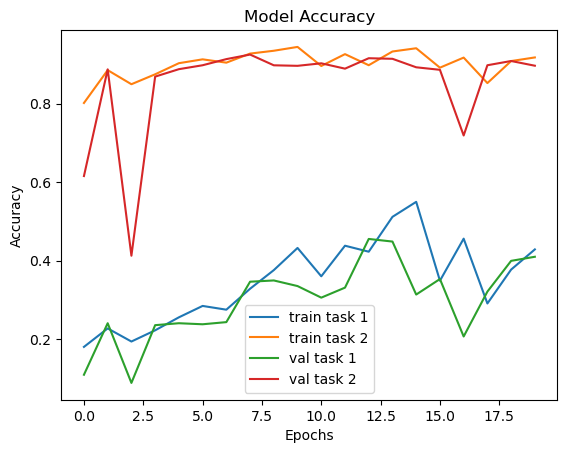

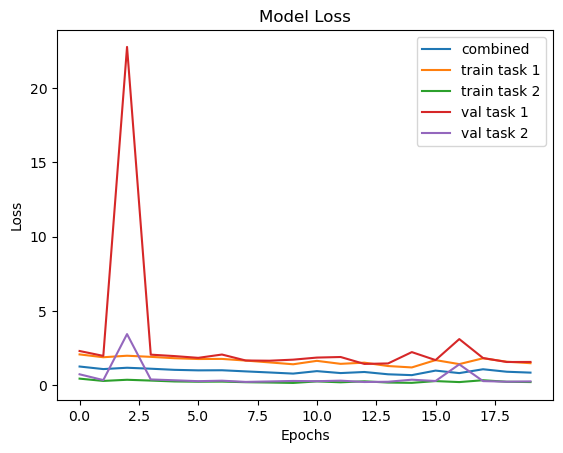

In [18]:
# accuracy plot
plt.plot(history_1.history['task_1_output_accuracy'])
plt.plot(history_1.history['task_2_output_accuracy'])
plt.plot(history_1.history['val_task_1_output_accuracy'])
plt.plot(history_1.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['task_1_output_loss'])
plt.plot(history_1.history['task_2_output_loss'])
plt.plot(history_1.history['val_task_1_output_loss'])
plt.plot(history_1.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.2. Case 2: Gamma = 0.6 - The model will receive loss 60% from task 1, 40% from task 2.
##      (Dropout = 0, Optimizer = Adam)

### Get Model

In [19]:
# define parameters and generate model
gamma=0.6
dropout = 0
optimizer = 'Adam'
model_2 = create_model(dropout)

In [20]:
# compile model
model_2.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [21]:
# train model
history_2 = model_2.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 137s 207ms/step - loss: 1.4680 - task_1_output_loss: 2.1245 - task_2_output_loss: 0.4831 - task_1_output_accuracy: 0.1736 - task_2_output_accuracy: 0.7614 - val_loss: 1.6000 - val_task_1_output_loss: 2.2457 - val_task_2_output_loss: 0.6315 - val_task_1_output_accuracy: 0.1144 - val_task_2_output_accuracy: 0.5813
Epoch 2/20
167/167 [==============================] - 32s 190ms/step - loss: 1.3546 - task_1_output_loss: 2.0020 - task_2_output_loss: 0.3835 - task_1_output_accuracy: 0.1882 - task_2_output_accuracy: 0.8251 - val_loss: 1.6990 - val_task_1_output_loss: 2.3758 - val_task_2_output_loss: 0.6837 - val_task_1_output_accuracy: 0.1675 - val_task_2_output_accuracy: 0.7229
Epoch 3/20
167/167 [==============================] - 32s 190ms/step - loss: 1.2484 - task_1_output_loss: 1.8955 - task_2_output_loss: 0.2777 - task_1_output_accuracy: 0.2035 - task_2_output_accuracy: 0.8874 - val_loss: 1.3151 - val_task_1_output_loss: 1.9890 - val

In [22]:
# train model results
print('Train loss:', history_2.history['loss'][-1])

print('\nTrain task 1 loss:', history_2.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_2.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_2.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_2.history['task_2_output_accuracy'][-1])

Train loss: 0.6464703679084778

Train task 1 loss: 1.0095503330230713
Train task 1 acc: 0.622423529624939

Train task 2 loss: 0.10184985399246216
Train task 2 acc: 0.9619058966636658


### Evaluate Model

In [23]:
# test model results
evaluation_results = model_2.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [24]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 1.6372661590576172

Test task 1 loss: 2.39261531829834
Test task 1 acc: 0.37709999084472656

Test task 2 loss: 0.5042439699172974
Test task 2 acc: 0.8805000185966492


### Plot Results

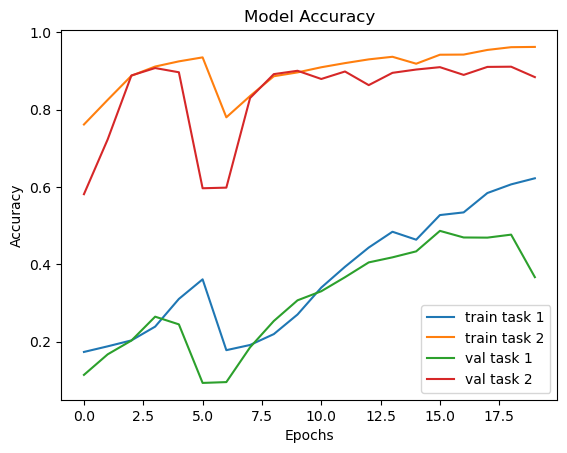

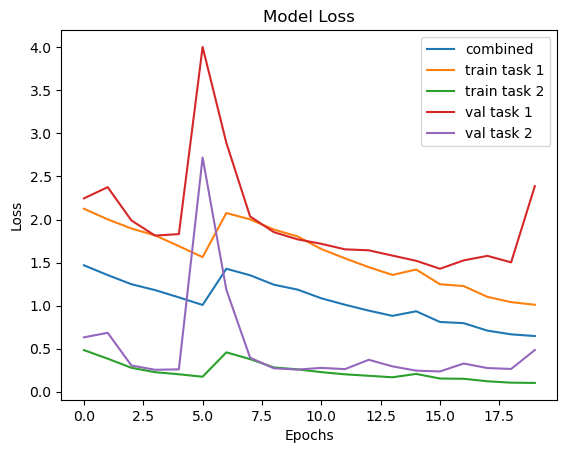

In [25]:
# accuracy plot
plt.plot(history_2.history['task_1_output_accuracy'])
plt.plot(history_2.history['task_2_output_accuracy'])
plt.plot(history_2.history['val_task_1_output_accuracy'])
plt.plot(history_2.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['task_1_output_loss'])
plt.plot(history_2.history['task_2_output_loss'])
plt.plot(history_2.history['val_task_1_output_loss'])
plt.plot(history_2.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.3. Case 3: Gamma = 0.4 - The model will receive loss 40% from task 1, 60% from task 2.
##      (Dropout = 0, Optimizer = Adam)

In [26]:
# define parameters and generate model
gamma=0.4
dropout = 0
optimizer = 'Adam'
model_3 = create_model(dropout)

In [27]:
# compile model
model_3.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [28]:
# train model
history_3 = model_3.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 137s 207ms/step - loss: 1.1093 - task_1_output_loss: 2.1035 - task_2_output_loss: 0.4466 - task_1_output_accuracy: 0.1738 - task_2_output_accuracy: 0.7952 - val_loss: 1.3921 - val_task_1_output_loss: 2.3873 - val_task_2_output_loss: 0.7286 - val_task_1_output_accuracy: 0.1081 - val_task_2_output_accuracy: 0.6041
Epoch 2/20
167/167 [==============================] - 32s 194ms/step - loss: 0.9931 - task_1_output_loss: 1.9628 - task_2_output_loss: 0.3466 - task_1_output_accuracy: 0.1972 - task_2_output_accuracy: 0.8488 - val_loss: 0.9923 - val_task_1_output_loss: 1.9919 - val_task_2_output_loss: 0.3260 - val_task_1_output_accuracy: 0.1944 - val_task_2_output_accuracy: 0.8649
Epoch 3/20
167/167 [==============================] - 32s 193ms/step - loss: 0.9404 - task_1_output_loss: 1.9044 - task_2_output_loss: 0.2977 - task_1_output_accuracy: 0.2157 - task_2_output_accuracy: 0.8792 - val_loss: 0.9202 - val_task_1_output_loss: 1.9109 - val

In [29]:
# train model results
print('Train loss:', history_3.history['loss'][-1])

print('\nTrain task 1 loss:', history_3.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_3.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_3.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_3.history['task_2_output_accuracy'][-1])

Train loss: 0.32555484771728516

Train task 1 loss: 0.7413008213043213
Train task 1 acc: 0.728847086429596

Train task 2 loss: 0.04839088395237923
Train task 2 acc: 0.9832941293716431


### Evaluate Model

In [30]:
# test model results
evaluation_results = model_3.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [31]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.6463478803634644

Test task 1 loss: 1.2764711380004883
Test task 1 acc: 0.5928000211715698

Test task 2 loss: 0.22626519203186035
Test task 2 acc: 0.9289000034332275


### Plot Results

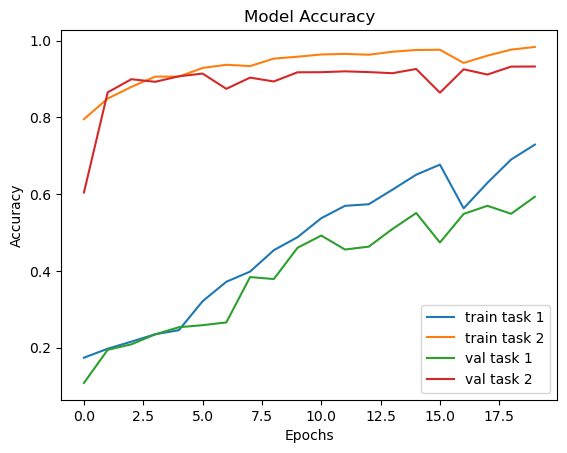

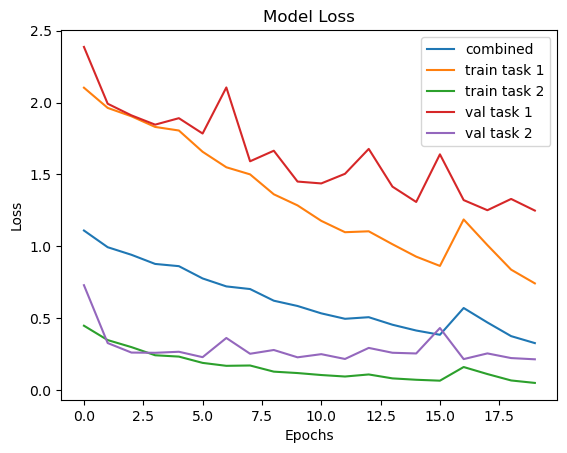

In [32]:
# accuracy plot
plt.plot(history_3.history['task_1_output_accuracy'])
plt.plot(history_3.history['task_2_output_accuracy'])
plt.plot(history_3.history['val_task_1_output_accuracy'])
plt.plot(history_3.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['task_1_output_loss'])
plt.plot(history_3.history['task_2_output_loss'])
plt.plot(history_3.history['val_task_1_output_loss'])
plt.plot(history_3.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.4. Case 4: Gamma = 0.5 - The model will receive loss evenly from task 1 and task 2.
##      (Dropout = 0.5, Optimizer = Adam)

In [33]:
# define parameters and generate model
gamma=0.5
dropout = 0.5
optimizer = 'Adam'
model_4 = create_model(dropout)

In [34]:
# compile model
model_4.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [35]:
# train model
history_4 = model_4.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 135s 211ms/step - loss: 1.2514 - task_1_output_loss: 2.0678 - task_2_output_loss: 0.4349 - task_1_output_accuracy: 0.1894 - task_2_output_accuracy: 0.8078 - val_loss: 2.0217 - val_task_1_output_loss: 2.8700 - val_task_2_output_loss: 1.1734 - val_task_1_output_accuracy: 0.1265 - val_task_2_output_accuracy: 0.5979
Epoch 2/20
167/167 [==============================] - 33s 194ms/step - loss: 1.1301 - task_1_output_loss: 1.9363 - task_2_output_loss: 0.3239 - task_1_output_accuracy: 0.2051 - task_2_output_accuracy: 0.8648 - val_loss: 1.1929 - val_task_1_output_loss: 1.9923 - val_task_2_output_loss: 0.3935 - val_task_1_output_accuracy: 0.2055 - val_task_2_output_accuracy: 0.8315
Epoch 3/20
167/167 [==============================] - 31s 187ms/step - loss: 0.9965 - task_1_output_loss: 1.7564 - task_2_output_loss: 0.2366 - task_1_output_accuracy: 0.2796 - task_2_output_accuracy: 0.9092 - val_loss: 1.1768 - val_task_1_output_loss: 2.0985 - val

In [36]:
# train model results
print('Train loss:', history_4.history['loss'][-1])

print('\nTrain task 1 loss:', history_4.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_4.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_4.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_4.history['task_2_output_accuracy'][-1])

Train loss: 0.5845798850059509

Train task 1 loss: 1.0605659484863281
Train task 1 acc: 0.604658842086792

Train task 2 loss: 0.10859362035989761
Train task 2 acc: 0.9626823663711548


### Evaluate Model

In [37]:
# test model results
evaluation_results = model_4.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [38]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.9486879110336304

Test task 1 loss: 1.6731435060501099
Test task 1 acc: 0.4309999942779541

Test task 2 loss: 0.2242322713136673
Test task 2 acc: 0.9323999881744385


### Plot Results

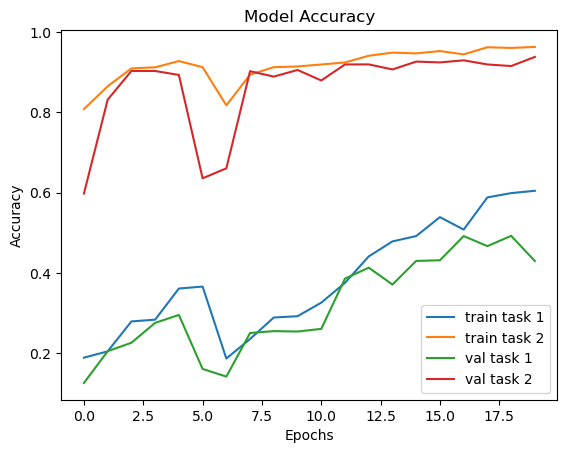

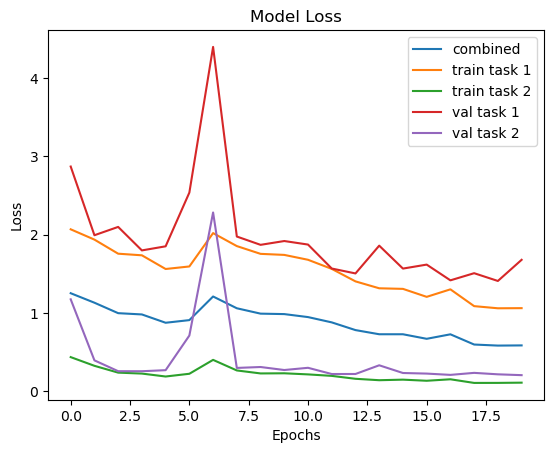

In [39]:
# accuracy plot
plt.plot(history_4.history['task_1_output_accuracy'])
plt.plot(history_4.history['task_2_output_accuracy'])
plt.plot(history_4.history['val_task_1_output_accuracy'])
plt.plot(history_4.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['task_1_output_loss'])
plt.plot(history_4.history['task_2_output_loss'])
plt.plot(history_4.history['val_task_1_output_loss'])
plt.plot(history_4.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.5. Case 5: Gamma = 0.5 - The model will receive loss evenly from task 1 and task 2.
##      (Dropout = 0.5, Optimizer = SGD)

In [40]:
# define parameters and generate model
gamma=0.5
dropout = 0.5
optimizer = 'SGD'
model_5 = create_model(dropout)

In [41]:
# compile model
model_5.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [42]:
# train model
history_5 = model_5.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 80s 206ms/step - loss: 1.5044 - task_1_output_loss: 2.3405 - task_2_output_loss: 0.6682 - task_1_output_accuracy: 0.1213 - task_2_output_accuracy: 0.6137 - val_loss: 494209630208.0000 - val_task_1_output_loss: 873224470528.0000 - val_task_2_output_loss: 115194961920.0000 - val_task_1_output_accuracy: 0.0999 - val_task_2_output_accuracy: 0.4021
Epoch 2/20
167/167 [==============================] - 30s 182ms/step - loss: 1.3498 - task_1_output_loss: 2.1677 - task_2_output_loss: 0.5320 - task_1_output_accuracy: 0.1727 - task_2_output_accuracy: 0.7422 - val_loss: 24.7198 - val_task_1_output_loss: 27.5313 - val_task_2_output_loss: 21.9082 - val_task_1_output_accuracy: 0.0840 - val_task_2_output_accuracy: 0.5979
Epoch 3/20
167/167 [==============================] - 30s 182ms/step - loss: 1.2678 - task_1_output_loss: 2.0765 - task_2_output_loss: 0.4591 - task_1_output_accuracy: 0.1952 - task_2_output_accuracy: 0.7908 - val_loss: 3.5674 - v

In [43]:
# train model results
print('Train loss:', history_5.history['loss'][-1])

print('\nTrain task 1 loss:', history_5.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_5.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_5.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_5.history['task_2_output_accuracy'][-1])

Train loss: 1.0290392637252808

Train task 1 loss: 1.770936369895935
Train task 1 acc: 0.3016941249370575

Train task 2 loss: 0.28714096546173096
Train task 2 acc: 0.8824235200881958


### Evaluate Model

In [44]:
# test model results
evaluation_results = model_5.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [45]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 1.9289021492004395

Test task 1 loss: 2.8147659301757812
Test task 1 acc: 0.10249999910593033

Test task 2 loss: 1.04303777217865
Test task 2 acc: 0.4878000020980835


### Plot Results

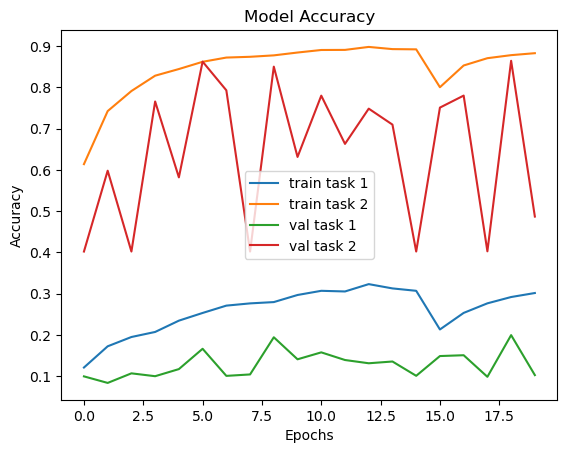

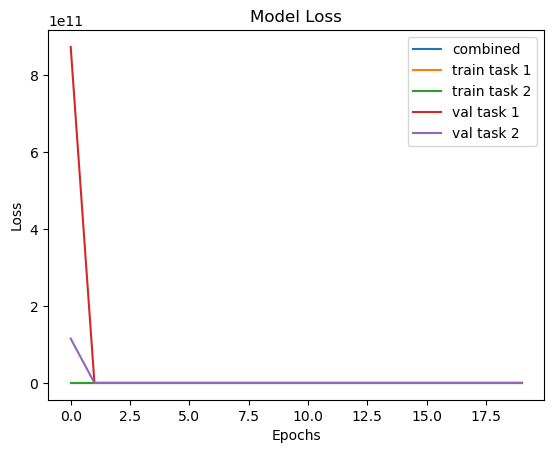

In [46]:
# accuracy plot
plt.plot(history_5.history['task_1_output_accuracy'])
plt.plot(history_5.history['task_2_output_accuracy'])
plt.plot(history_5.history['val_task_1_output_accuracy'])
plt.plot(history_5.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['task_1_output_loss'])
plt.plot(history_5.history['task_2_output_loss'])
plt.plot(history_5.history['val_task_1_output_loss'])
plt.plot(history_5.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()